In [40]:
import pandas as pd
import numpy as np
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_val_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [41]:
# Reading data
df = pd.read_csv("DATA.csv")
df.head()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,NaN,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,NaN,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive


In [42]:
# Check duplicated rows
df.duplicated().sum()

0

In [43]:
# Check null values
df.isnull().sum()

Patient_ID                           0
Systemic Illness                  6216
Rectal Pain                          0
Sore Throat                          0
Penile Oedema                        0
Oral Lesions                         0
Solitary Lesion                      0
Swollen Tonsils                      0
HIV Infection                        0
Sexually Transmitted Infection       0
MonkeyPox                            0
dtype: int64

In [44]:
# Drop irrelevant column
df.drop(columns=['Patient_ID'], inplace=True)

In [45]:
# Fill in null values
df['Systemic Illness'].fillna('None', inplace=True)

In [46]:
# Encoding categorical values (Systemic Illness)
encoded_data = pd.get_dummies(df['Systemic Illness'], prefix='Systemic Illness')
df = pd.concat([df, encoded_data], axis=1)
df = df.drop(['Systemic Illness', 'Systemic Illness_None'], axis=1) 
df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_Swollen Lymph Nodes
0,False,True,True,True,False,True,False,False,Negative,False,False,False
1,True,False,True,True,False,False,True,False,Positive,True,False,False
2,False,True,True,False,False,False,True,False,Positive,True,False,False
3,True,False,False,False,True,True,True,False,Positive,False,False,False
4,True,True,True,False,False,True,True,False,Positive,False,False,True


In [47]:
# Encoding binary values
mapping = {
        True: 1,
        False: 0,
        "Positive": 1,
        "Negative": 0
}
df = df.applymap(lambda x: mapping.get(x, x))
df.sample(5)

C:\Users\Asus\AppData\Local\Temp\ipykernel_20832\2829669467.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: mapping.get(x, x))


,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_Swollen Lymph Nodes
2372,0,1,1,1,0,0,1,1,1,1,0,0
12111,1,1,0,0,1,0,1,1,1,0,0,1
23425,0,1,1,1,1,1,0,1,0,0,0,0
5065,0,1,1,0,0,0,1,1,0,0,0,1
20851,1,1,1,1,1,0,0,0,0,0,1,0


In [48]:
# Create sum column for symptoms sum
df['sum'] = df.sum(axis=1)

<Axes: >

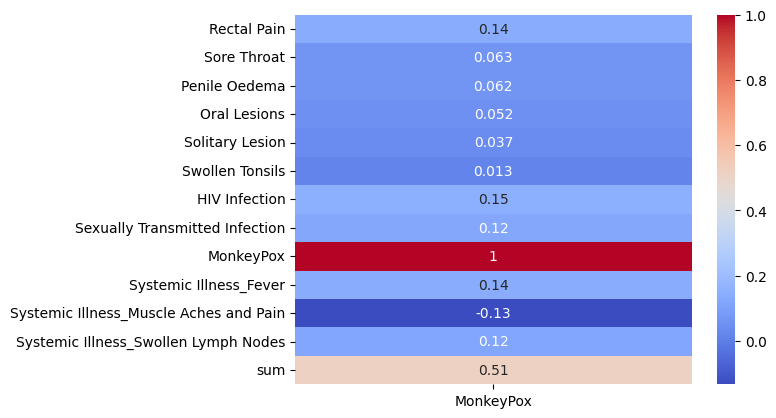

In [49]:
# Correlation mapping
# 'Sum' Column correlates well with the target column, therefore the total amount of symptoms may be an important feature.
sns.heatmap(df.corr()[['MonkeyPox']], cmap='coolwarm', annot=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Rectal Pain                             25000 non-null  int64
 1   Sore Throat                             25000 non-null  int64
 2   Penile Oedema                           25000 non-null  int64
 3   Oral Lesions                            25000 non-null  int64
 4   Solitary Lesion                         25000 non-null  int64
 5   Swollen Tonsils                         25000 non-null  int64
 6   HIV Infection                           25000 non-null  int64
 7   Sexually Transmitted Infection          25000 non-null  int64
 8   MonkeyPox                               25000 non-null  int64
 9   Systemic Illness_Fever                  25000 non-null  int64
 10  Systemic Illness_Muscle Aches and Pain  25000 non-null  int64
 11  Systemic Illnes

In [51]:
# Shuffle dataset and check for data distribution
df = shuffle(df)
df['MonkeyPox'].value_counts()

MonkeyPox
1    15909
0     9091
Name: count, dtype: int64

In [52]:
# Splitting dataset to train and test with 0.3 ratio
X = df.drop('MonkeyPox', axis = 1)
y = df['MonkeyPox']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [53]:
# Random undersampling to balance data
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_train, y_train = rus.fit_resample(X_train, y_train)
print(y_train.value_counts())

MonkeyPox
0    6364
1    6364
Name: count, dtype: int64


In [54]:
# Function for model evaluation
def model_evaluation(model_name, y_test, predictions):
  accuracy = accuracy_score(y_test, predictions)
  precision = precision_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  print(f"========= {model_name.upper()} EVALUATION =========")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("f1_score:", f1)
  
  cm = confusion_matrix(y_test, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()

========= XGBOOST CLASSIFIER EVALUATION =========
Accuracy: 0.9978666666666667
Precision: 0.9995799201848351
Recall: 0.9970668342761366
f1_score: 0.998321795678624


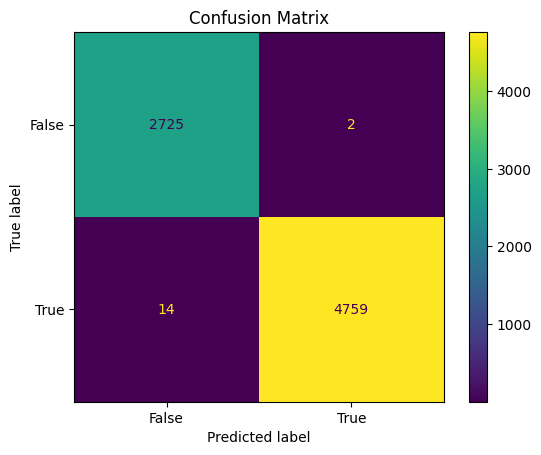

In [55]:
# Classification using XGBoost
XGBOOST_MODEL = XGBClassifier()
XGBOOST_MODEL.fit(X_train, y_train)
pred = XGBOOST_MODEL.predict(X_test)
model_evaluation("XGBOOST CLASSIFIER", y_test, pred)

========= DECISION TREE EVALUATION =========
Accuracy: 0.9942666666666666
Precision: 0.9947698744769874
Recall: 0.9962287869264613
f1_score: 0.9954987961896786


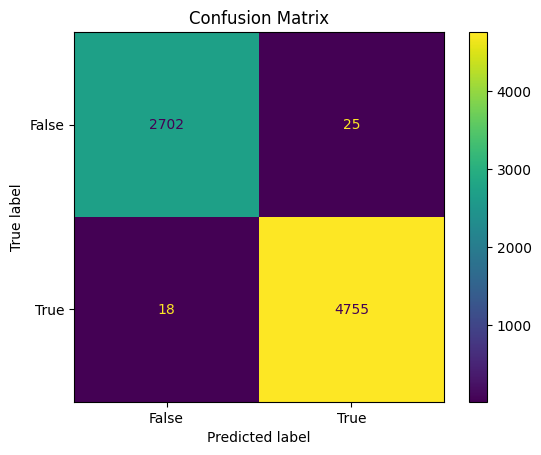

In [56]:
# Classification using Decision Tree
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
pred = DecisionTree.predict(X_test)
model_evaluation("Decision Tree", y_test, pred)

========= RANDOM FOREST EVALUATION =========
Accuracy: 0.9942666666666666
Precision: 0.9947698744769874
Recall: 0.9962287869264613
f1_score: 0.9954987961896786


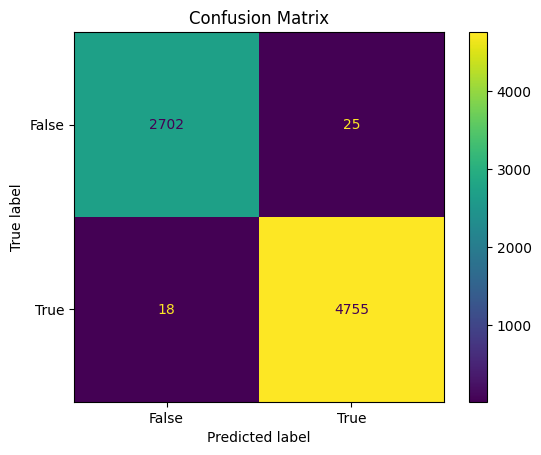

In [57]:
# Classification using Random Forest
RandomForest = RandomForestClassifier(n_estimators= 1000, random_state=42)
RandomForest.fit(X_train, y_train)
pred = RandomForest.predict(X_test)
model_evaluation("Random Forest", y_test, pred)

========= SVM CLASSIFIER EVALUATION =========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1_score: 1.0


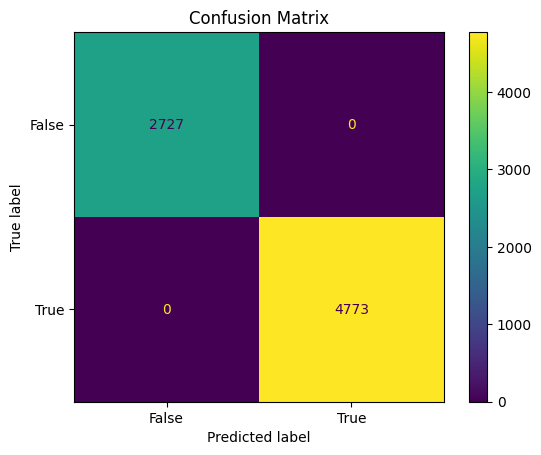

In [58]:
# Classification using Support Vector Classifier
SVM = SVC()
SVM.fit(X_train, y_train)
pred = SVM.predict(X_test)
model_evaluation("SVM Classifier", y_test, pred)

========= NAIVE BAYES EVALUATION =========
Accuracy: 0.7086666666666667
Precision: 0.8082420200095284
Recall: 0.7108736643620365
f1_score: 0.7564374094303867


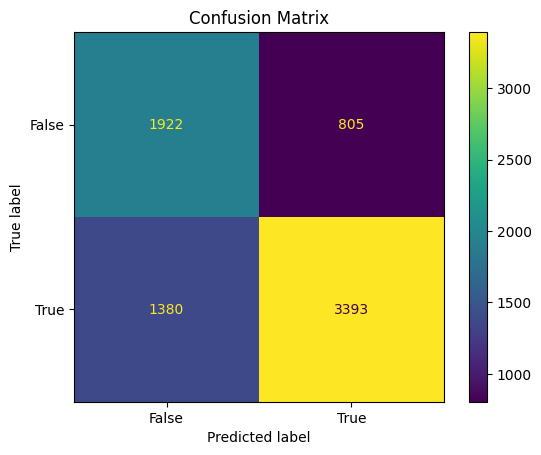

In [59]:
# Classification using Naive Bayes
NaiveBayes = GaussianNB()
NaiveBayes.fit(X_train, y_train)
pred = NaiveBayes.predict(X_test)
model_evaluation("Naive Bayes", y_test, pred)

========= KNN EVALUATION =========
Accuracy: 0.8565333333333334
Precision: 0.8981262115011845
Recall: 0.873664362036455
f1_score: 0.8857264231096007


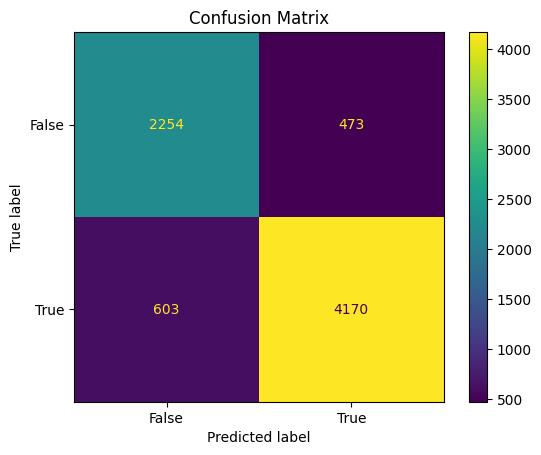

In [60]:
# Classification using K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)
pred = KNN.predict(X_test)
model_evaluation("KNN", y_test, pred)

========= LOGISTIC REGRESSION EVALUATION =========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1_score: 1.0


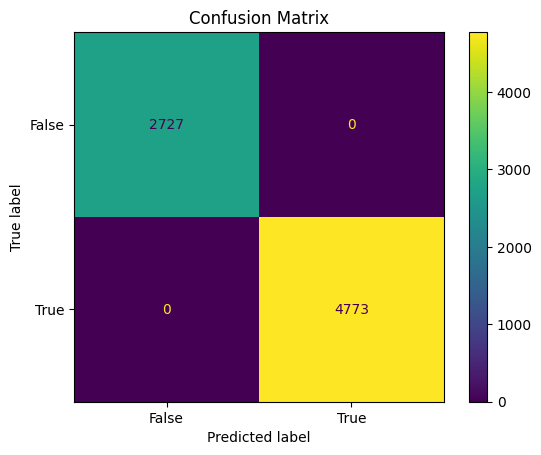

In [61]:
#Classification using Logistic Regression
LogisticReg = LogisticRegression()
LogisticReg.fit(X_train, y_train)
pred = LogisticReg.predict(X_test)
model_evaluation("Logistic Regression", y_test, pred)

========= L1 LOGISTIC EVALUATION =========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1_score: 1.0


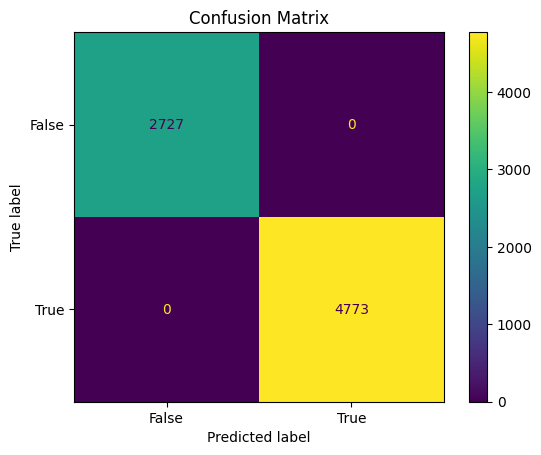

In [62]:
# L1 Regularization (Lasso) Logistic Regression
lasso_log_reg = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=10000)
lasso_log_reg.fit(X_train, y_train)
pred = lasso_log_reg.predict(X_test)
model_evaluation("L1 Logistic", y_test, pred)

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

========= SVM_PCA EVALUATION =========
Accuracy: 0.7504
Precision: 0.8036424534226502
Recall: 0.8043159438508276
f1_score: 0.803979057591623


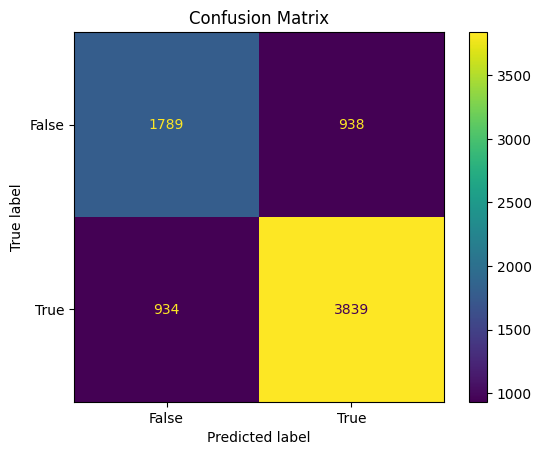

In [73]:
SVM_PCA = SVC()
SVM_PCA.fit(X_train_pca, y_train)
pred = SVM_PCA.predict(X_test_pca)
model_evaluation("SVM_PCA", y_test, pred)

In [63]:
def save_model(model, name):
  file = open(name+'.pickle', "wb")
  pkl.dump(model, file)
  file.close()

In [69]:
save_model(pca, "PCA")

In [74]:
save_model(SVM_PCA, "SVM_PCA")